In [1]:
import numpy as np # Calculs numériques
import pandas as pd # Manipulation de données
import os # Gestion des fichiers et dossiers
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Input,Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

2025-11-02 11:57:02.683754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762084622.707278     400 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762084622.714097     400 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Définition des chemins
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir   = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir  = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Vérification du contenu
print("Dossiers dans train_dir :", os.listdir(train_dir))
print("Dossiers dans val_dir   :", os.listdir(val_dir))
print("Dossiers dans test_dir  :", os.listdir(test_dir))

Dossiers dans train_dir : ['PNEUMONIA', 'NORMAL']
Dossiers dans val_dir   : ['PNEUMONIA', 'NORMAL']
Dossiers dans test_dir  : ['PNEUMONIA', 'NORMAL']


In [3]:
import os
import shutil
import random

# Chemin du dataset original
original_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Nouveau dossier pour dataset réorganisé
base_dir = "/kaggle/working/chest_xray_split"
os.makedirs(base_dir, exist_ok=True)

for subset in ["train", "val", "test"]:
    for cls in ["NORMAL", "PNEUMONIA"]:
        os.makedirs(os.path.join(base_dir, subset, cls), exist_ok=True)

# Rassembler toutes les images par classe
for cls in ["NORMAL", "PNEUMONIA"]:
    all_images = []
    for folder in ["train", "val", "test"]:
        folder_path = os.path.join(original_dir, folder, cls)
        all_images += [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    
    random.shuffle(all_images)
    
    n_total = len(all_images)
    n_train = int(0.7 * n_total)
    n_val   = int(0.15 * n_total)
    n_test  = n_total - n_train - n_val

    # Copier les images dans les nouveaux dossiers
    for i, img_path in enumerate(all_images):
        if i < n_train:
            target = os.path.join(base_dir, "train", cls, os.path.basename(img_path))
        elif i < n_train + n_val:
            target = os.path.join(base_dir, "val", cls, os.path.basename(img_path))
        else:
            target = os.path.join(base_dir, "test", cls, os.path.basename(img_path))
        shutil.copy(img_path, target)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Définition des chemins du nouveau dataset
train_dir = "/kaggle/working/chest_xray_split/train"
val_dir   = "/kaggle/working/chest_xray_split/val"
test_dir  = "/kaggle/working/chest_xray_split/test"

# -----------------------------
# Générateurs d'images
# -----------------------------

# Générateur pour l'entraînement (avec augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Générateur pour validation (pas d'augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Générateur pour test (pas d'augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# -----------------------------
# Création des datasets
# -----------------------------

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5705 images belonging to 2 classes.
Found 2248 images belonging to 2 classes.
Found 2253 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


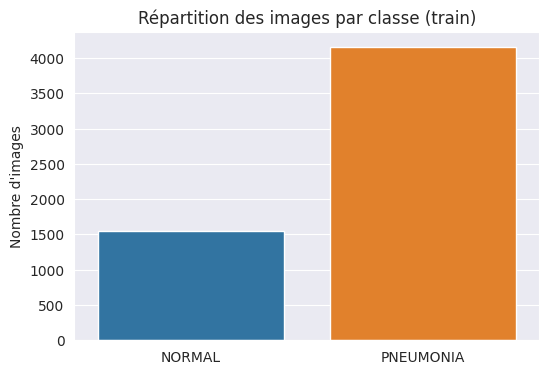

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


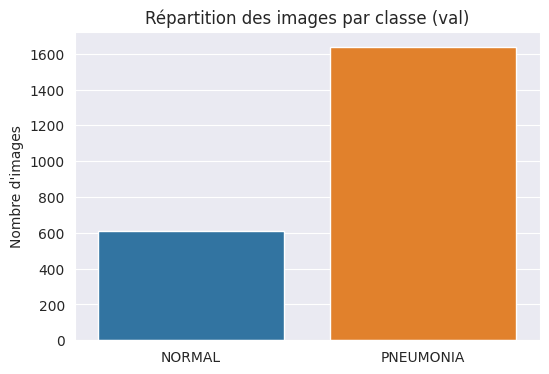

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


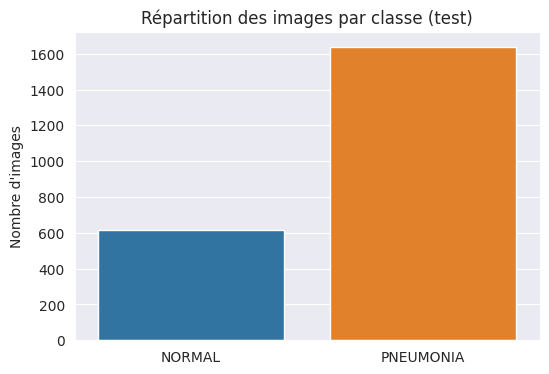

In [5]:
def plot_class_distribution_from_dir(base_dir, subset_name):
    classes = ["NORMAL", "PNEUMONIA"]
    counts = []
    for cls in classes:
        cls_path = os.path.join(base_dir, subset_name, cls)
        counts.append(len(os.listdir(cls_path)))
    
    # Graphique
    sns.set_style('darkgrid')
    plt.figure(figsize=(6,4))
    sns.barplot(x=classes, y=counts)
    plt.title(f"Répartition des images par classe ({subset_name})")
    plt.ylabel("Nombre d'images")
    plt.show()

# Train
plot_class_distribution_from_dir(base_dir, "train")

# Validation
plot_class_distribution_from_dir(base_dir, "val")

# Test
plot_class_distribution_from_dir(base_dir, "test")

In [6]:
import os

# Chemins des dossiers
base_dir = "/kaggle/working/chest_xray_split"
subsets = ["train", "val", "test"]
classes = ["NORMAL", "PNEUMONIA"]

# Parcours et comptage
for subset in subsets:
    print(f"\n--- {subset.upper()} ---")
    subset_path = os.path.join(base_dir, subset)
    for cls in classes:
        cls_path = os.path.join(subset_path, cls)
        n_images = len(os.listdir(cls_path))
        print(f"{cls}: {n_images} images")



--- TRAIN ---
NORMAL: 1549 images
PNEUMONIA: 4156 images

--- VAL ---
NORMAL: 610 images
PNEUMONIA: 1638 images

--- TEST ---
NORMAL: 615 images
PNEUMONIA: 1638 images


Mapping des classes : {'NORMAL': 0, 'PNEUMONIA': 1}


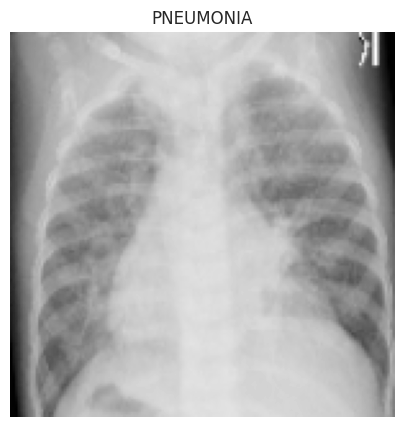

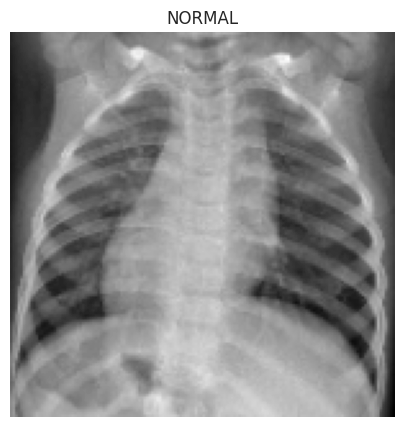

In [7]:
# Vérifier le mapping des classes
print("Mapping des classes :", train_data.class_indices)
# Exemple possible : {'NORMAL': 0, 'PNEUMONIA': 1}

# Récupérer un batch d'images et labels
images, labels_batch = next(train_data)

# Trouver la première image PNEUMONIA et NORMAL
pneumonia_img = None
normal_img = None

for i in range(len(labels_batch)):
    if labels_batch[i] == train_data.class_indices['PNEUMONIA'] and pneumonia_img is None:
        pneumonia_img = images[i]
    if labels_batch[i] == train_data.class_indices['NORMAL'] and normal_img is None:
        normal_img = images[i]
    if pneumonia_img is not None and normal_img is not None:
        break

# Affichage PNEUMONIA
plt.figure(figsize=(5,5))
plt.imshow(pneumonia_img.squeeze(), cmap='gray')  # .squeeze() pour enlever la dimension inutile
plt.title('PNEUMONIA')
plt.axis('off')
plt.show()

# Affichage NORMAL
plt.figure(figsize=(5,5))
plt.imshow(normal_img.squeeze(), cmap='gray')
plt.title('NORMAL')
plt.axis('off')
plt.show()


In [8]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(150,150,1)))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC']
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1762084636.362515     400 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762084636.364155     400 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [9]:
# -----------------------------
# Calcul des class weights
# -----------------------------
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = train_data.classes  # labels du train set
class_weights = compute_class_weight('balanced', classes=np.unique(classes), y=classes)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# -----------------------------
# Callbacks pour l'entraînement
# -----------------------------
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


Class weights: {0: 1.84151065203357, 1: 0.6863570741097209}


In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1762084643.909371     473 service.cc:148] XLA service 0x7edc8c002660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762084643.909423     473 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762084643.909431     473 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762084644.556410     473 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/179 ━━━━━━━━━━━━━━━━━━━━ 42:28 14s/step - AUC: 0.5974 - accuracy: 0.4688 - loss: 0.8581

I0000 00:00:1762084652.251206     473 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 74s 336ms/step - AUC: 0.9139 - accuracy: 0.8389 - loss: 0.3946 - val_AUC: 0.5677 - val_accuracy: 0.7286 - val_loss: 1.1484
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 281ms/step - AUC: 0.9689 - accuracy: 0.9161 - loss: 0.2260 - val_AUC: 0.5000 - val_accuracy: 0.7286 - val_loss: 2.1550
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - AUC: 0.9797 - accuracy: 0.9338 - loss: 0.1758 - val_AUC: 0.9701 - val_accuracy: 0.7642 - val_loss: 0.5526
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 280ms/step - AUC: 0.9804 - accuracy: 0.9243 - loss: 0.1770 - val_AUC: 0.9888 - val_accuracy: 0.9515 - val_loss: 0.1256
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 282ms/step - AUC: 0.9829 - accuracy: 0.9325 - loss: 0.1655 - val_AUC: 0.9888 - val_accuracy: 0.9462 - val_loss: 0.1316
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - AUC: 0.9867 - accuracy: 0.9440 - loss: 0.1429 - val_AUC: 0.9902 - val_accuracy: 0.8772 - val_loss: 0.2918
Epoch 7/30
179/179 ━━━━━━━━━━━━━━

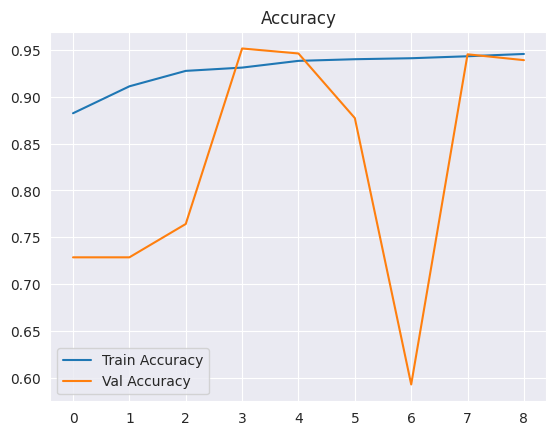

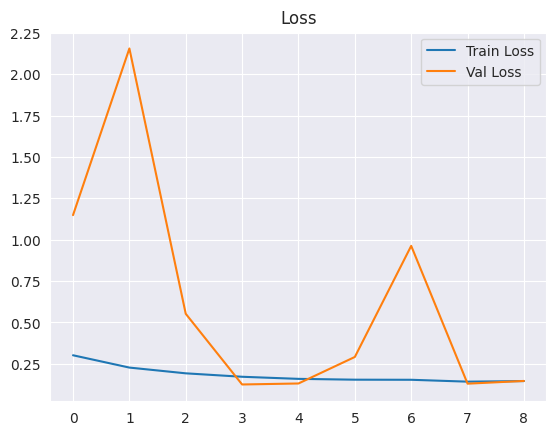

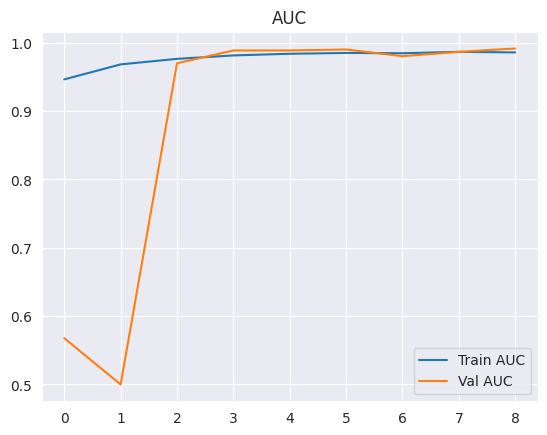

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(history.history['AUC'], label='Train AUC')
plt.plot(history.history['val_AUC'], label='Val AUC')
plt.legend()
plt.title('AUC')
plt.show()

In [13]:
test_loss, test_acc, test_auc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - AUC: 0.9896 - accuracy: 0.9502 - loss: 0.1232
Test Accuracy: 0.9494, Test AUC: 0.9903


71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step


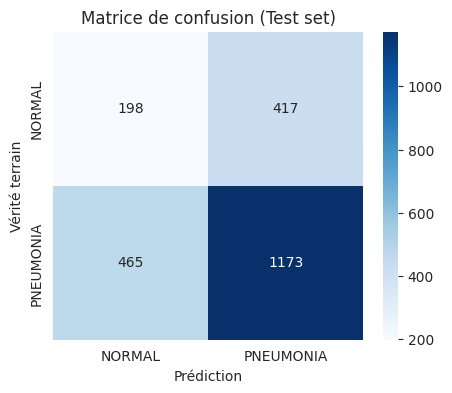

              precision    recall  f1-score   support

      NORMAL       0.30      0.32      0.31       615
   PNEUMONIA       0.74      0.72      0.73      1638

    accuracy                           0.61      2253
   macro avg       0.52      0.52      0.52      2253
weighted avg       0.62      0.61      0.61      2253



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prédictions sur le test set
Y_pred = model.predict(test_data)
y_pred = (Y_pred > 0.5).astype(int)

# Matrice de confusion
cm = confusion_matrix(test_data.classes, y_pred)
labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prédiction')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion (Test set)')
plt.show()

# Rapport détaillé
print(classification_report(test_data.classes, y_pred, target_names=labels))
